<a href="https://colab.research.google.com/github/Rayzon3/Natural-Language-Processing/blob/main/Sentiment_140_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.3.0


In [3]:
df = pd.read_csv('/content/drive/My Drive/Dataset/sentiment140.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
#renaming cols
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
#droping other cols
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [6]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

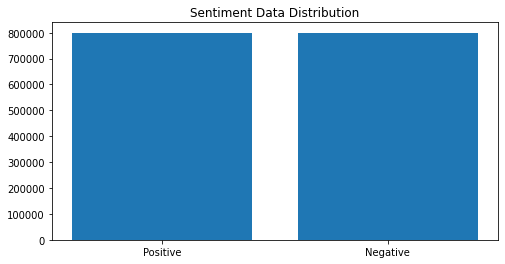

In [7]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [8]:
#stemming/lemanization

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
#cleaning data

def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [10]:
df.text = df.text.apply(lambda x: preprocess(x))

In [11]:
#data cleaned!

df.head()

,sentiment,text
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


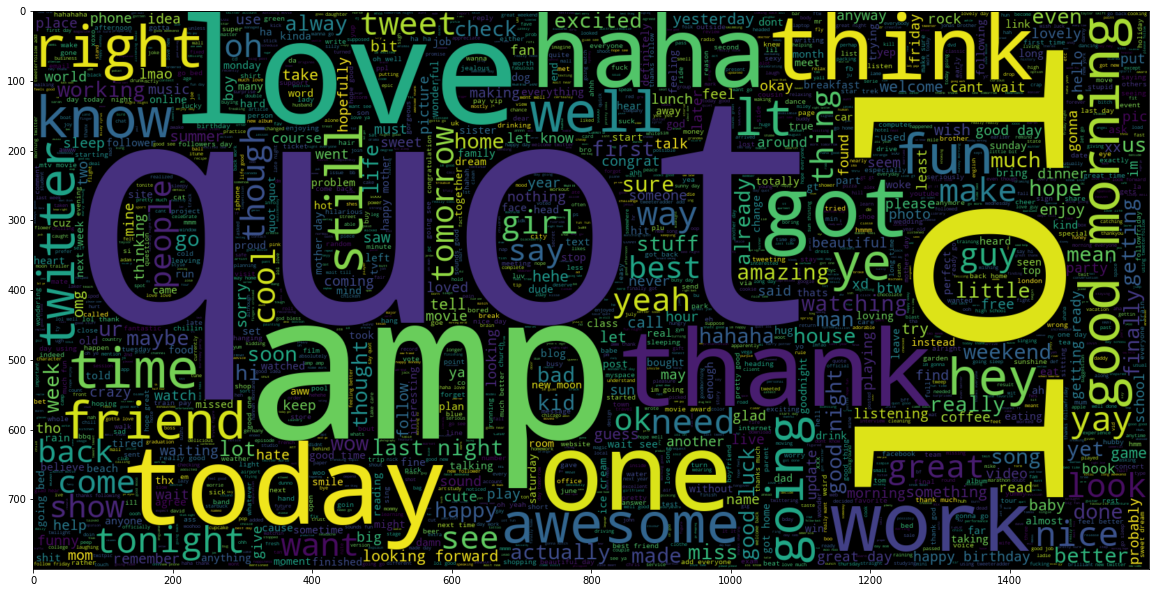

In [12]:
#making wordCloud for positive words

from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

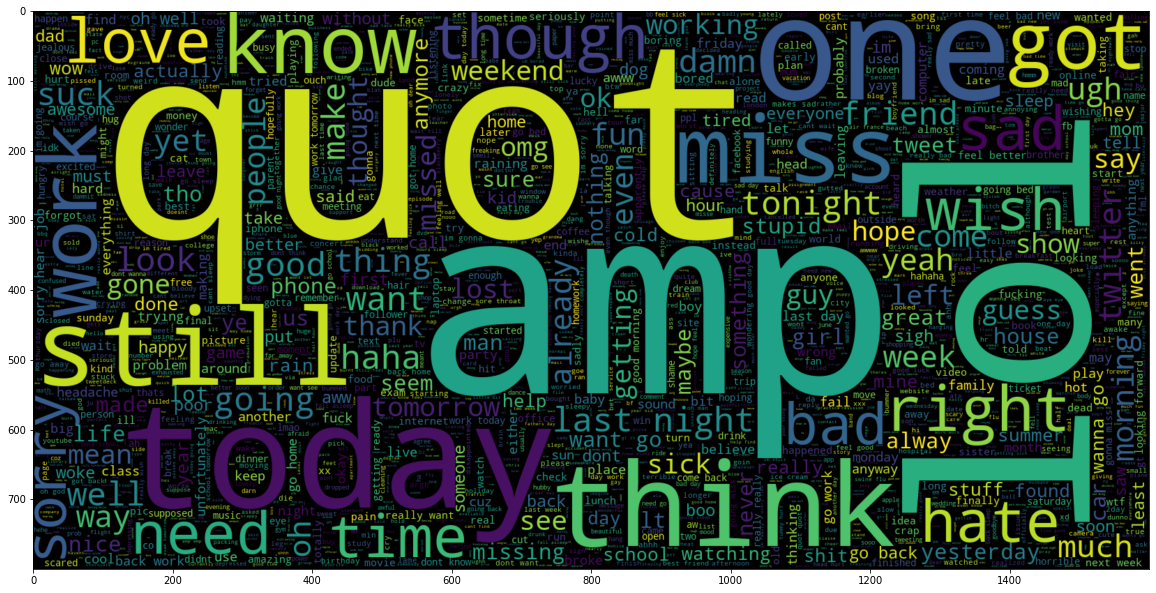

In [13]:
#making wordCloud for negative words

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [14]:
#test and train split

TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [15]:
train_data.head()

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...


In [16]:
#Tokenization

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [17]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [18]:
labels = train_data.sentiment.unique().tolist()

In [19]:
#Label Encoding

encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [20]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2020-11-26 01:17:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-26 01:17:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-26 01:17:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [21]:
#Word embeddings using GloVe 
#Word2Vec can also be used

GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '/content/model.hdf5'

In [22]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [23]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [24]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [25]:
#training LSTM model

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [50]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [52]:
#training

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

model.save('Sentiment_LSTM_model.h5')
with open('trainHistoryDict', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/10
1250/1250 [==============================] - 134s 107ms/step - loss: 0.4533 - accuracy: 0.7839 - val_loss: 0.4569 - val_accuracy: 0.7835
Epoch 2/10
1250/1250 [==============================] - 133s 107ms/step - loss: 0.4517 - accuracy: 0.7847 - val_loss: 0.4597 - val_accuracy: 0.7829
Epoch 3/10
1250/1250 [==============================] - 132s 106ms/step - loss: 0.4506 - accuracy: 0.7854 - val_loss: 0.4567 - val_accuracy: 0.7836
Epoch 4/10
1250/1250 [==============================] - 132s 106ms/step - loss: 0.4495 - accuracy: 0.7863 - val_loss: 0.4542 - val_accuracy: 0.7840
Epoch 5/10
1250/1250 [==============================] - 133s 107ms/step - loss: 0.4489 - accuracy: 0.7867 - val_loss: 0.4550 - val_accuracy: 0.7842
Epoch 6/10
1250/1250 [==============================] - 133s 107ms/step - loss: 0.4480 - accuracy: 0.7868 - val_loss: 0.4543 - val_accuracy: 0.7844
Epoch 7/10
1250/1250 [==============================] - 131s 105ms/step - loss: 0.4470 - accuracy: 0.7876 - val_

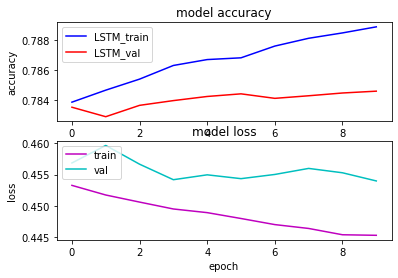

In [54]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [55]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    if(score >=0.4 and score<=0.6):
        label = "Neutral"
    if(score <=0.4):
        label = "Negative"
    if(score >=0.6):
        label = "Positive"

    return {"label" : label,
        "score": float(score)}

In [56]:
predict("This is cool")

{'label': 'Positive', 'score': 0.8865711092948914}